In [115]:
require(tidyr)
require(ggplot2)

In [116]:
cubicDF = read.csv("../Results/cubic_model.csv")
flschDF = read.csv("../Results/full_scholfield_model.csv")
nhschDF = read.csv("../Results/noh_scholfield_model.csv")
nlschDF = read.csv("../Results/nol_scholfield_model.csv")
arrhnDF = read.csv("../Results//arrhenius_model.csv")

aicdf = data.frame("NewID" = cubicDF$NewID,
                  "cubic" = cubicDF$aic,
                  "flsch" = flschDF$aic,
                  "nhsch" = nhschDF$aic,
                  "nlsch" = nlschDF$aic,
                  "arrhn" = arrhnDF$aic)

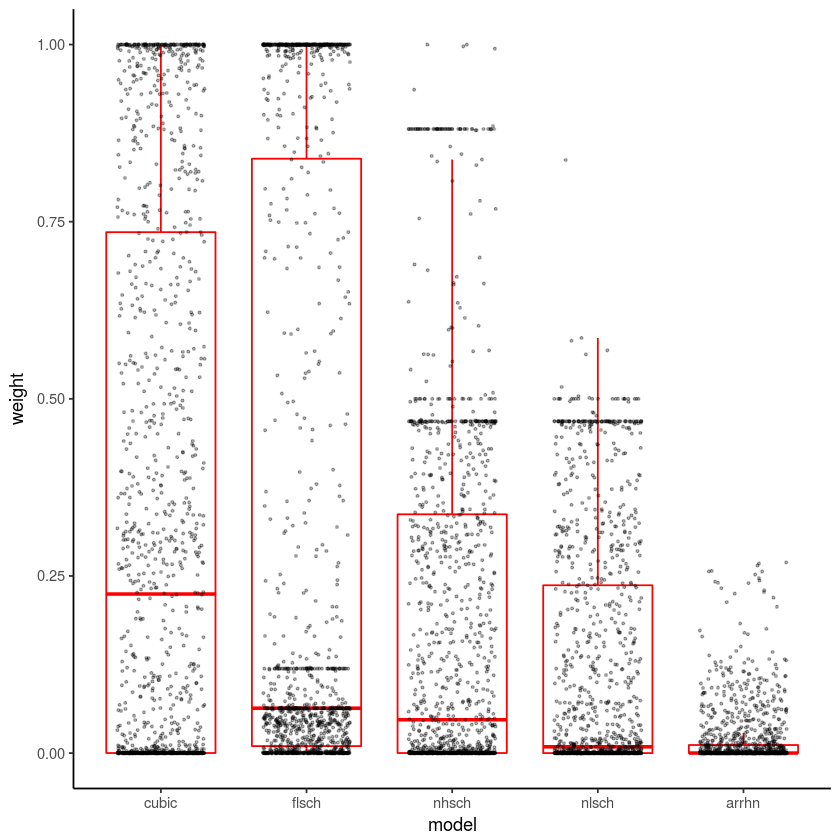

In [254]:
mdls = c("cubic", "flsch", "nhsch", "nlsch", "arrhn")#
#mdls = c("flsch", "nlsch", "arrhn")

delta = function(row, model){
    abs(min(row, na.rm = TRUE) - row[model])
}

weight = function(row, model_delta, comparing){
    if (is.na(row[model_delta])){
        0
    } else{
        exp(-.5*row[model_delta])/sum(exp(-.5*row[comparing]), na.rm = TRUE)
    }
}

compare = function(models){

    DFaic    = paste0(models, "DF$aic")
    DFdelta  = paste0(models, "_delta")
    DFweight = paste0(models, "_weight")


    aicDF = data.frame("NewID" = eval(parse(text = (paste0(models[1], "DF$NewID")))))

    for (i in 1:length(models)){
        aicDF = cbind(aicDF, eval(parse(text = DFaic[i])))
    }
    
    colnames(aicDF) = c("NewID", models)
    
    for (i in 1:length(models)){
    aicDF[DFdelta[i]] = apply(aicDF, 1, delta, model = mdls[i])
    }

    for (i in 1:length(models)){
    aicDF[DFweight[i]] =  apply(aicDF, 1, weight, model_delta = DFdelta[i],
                               comparing = DFdelta)
    }
    
    
    pltDF = data.frame(NewID  = aicDF$NewID, model = mdls[1],
                   aic    = eval(parse(text = DFaic[1])),
                   delta  = eval(parse(text = paste0("aicDF$",DFdelta[1]))), 
                   weight = eval(parse(text = paste0("aicDF$",DFweight[1]))))

    for(i in 2:length(mdls)){
        pltDF = rbind.data.frame(pltDF,
                                 data.frame(NewID  = aicDF$NewID, model = models[i],
                                            aic    = eval(parse(text = DFaic[1])),
                                            delta  = eval(parse(text = paste0("aicDF$",DFdelta[i]))), 
                                            weight = eval(parse(text = paste0("aicDF$",DFweight[i])))))
    }
    
    plt = ggplot(data = pltDF, aes(y = weight, x = model))
    plt = plt + geom_boxplot(outlier.shape=NA, colour = "red")
    plt = plt + geom_jitter(position=position_jitter(width=.3, height=0), alpha = 0.3, cex = .5)
    plt = plt + theme_classic()
    print(plt)

    return(aicDF)
}


aicDF = compare(mdls)


In [251]:
a = aicDF[which(aicDF$arrhn_weight > 0.244),]
a = a[which(a$arrhn_weight < 0.246),]
nrow(a)

[1] 67

In [252]:
a

,NewID,flsch,nlsch,arrhn,flsch_delta,nlsch_delta,arrhn_delta,flsch_weight,nlsch_weight,arrhn_weight
14,17,-3.7151168,-7.7151168,-5.715117,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285
15,18,-3.8296711,-7.8296717,-5.829671,4.000001,0,2.000000,0.09003055,0.6652410,0.2447284
16,19,-40.4528411,-44.4528459,-42.452846,4.000005,0,2.000000,0.09003038,0.6652411,0.2447285
202,514,-8.7447491,-12.7447491,-10.742295,4.000000,0,2.002454,0.09005760,0.6654407,0.2445017
208,520,-8.7897840,-12.7897840,-10.789784,4.000000,0,2.000000,0.09003058,0.6652410,0.2447284
213,526,-0.4569896,-4.4569896,-2.456989,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285
233,588,3.6077854,-0.3922148,1.607785,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285
275,652,-25.8959475,-29.8959493,-27.895949,4.000002,0,2.000001,0.09003050,0.6652411,0.2447284
277,654,-20.6019064,-24.6019064,-22.601452,4.000000,0,2.000454,0.09003558,0.6652779,0.2446865
299,685,-16.1897391,-20.1897391,-18.189739,4.000000,0,2.000000,0.09003057,0.6652410,0.2447285


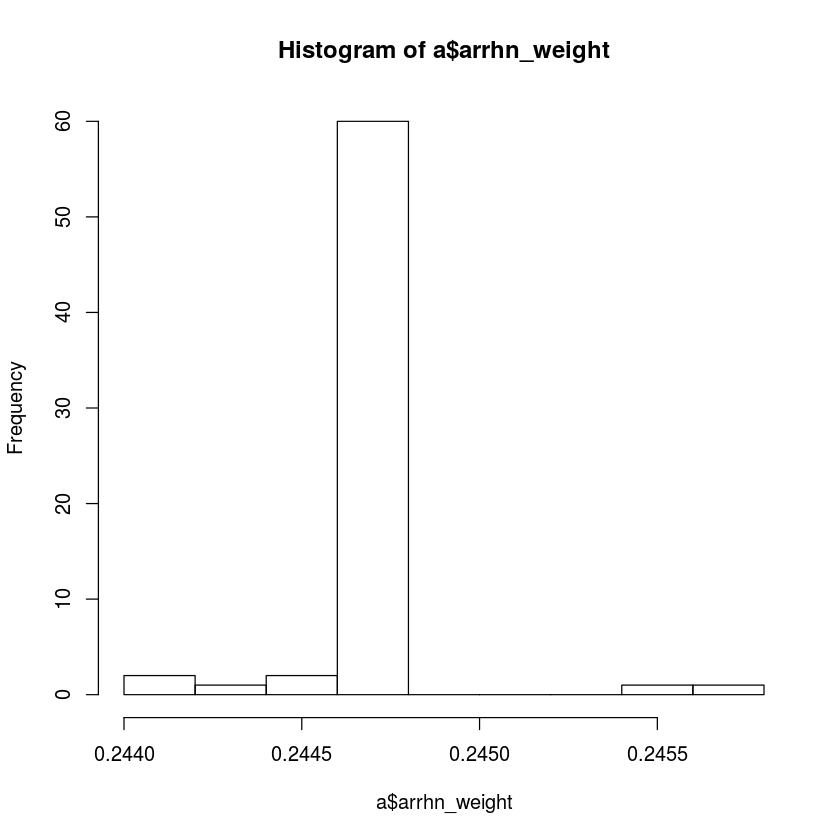

In [253]:
hist(a$arrhn_weight)